In [19]:
import warnings
warnings.filterwarnings('ignore')

import glob
import json 
import os 
import torchaudio
from pathlib import Path
import sys
from tqdm import tqdm
import uuid
import speechbrain
import matplotlib
import torch

In [3]:
dev_clean_root = "/media/voxLingua"
wav_files = glob.glob(os.path.join(dev_clean_root, "**/*.wav"), recursive=True)
print("total wav audio files {}".format(len(wav_files)))

total wav audio files 94346


In [4]:
print(wav_files[0])

/media/voxLingua/hi/pS2L7-_mxO4__U__S11---0316.180-0323.160.wav


In [29]:
def splitall(path):
    allparts = []
    while 1:
        parts = os.path.split(path)
        if parts[0] == path:  # sentinel for absolute paths
            allparts.insert(0, parts[0])
            break
        elif parts[1] == path: # sentinel for relative paths
            allparts.insert(0, parts[1])
            break
        else:
            path = parts[0]
            allparts.insert(0, parts[1])
    return allparts

examples = {}
for utterance in tqdm(wav_files):
  utt_split = splitall(utterance)
  examples[utt_split[-1][:-4]] = {"file_path": utterance, 
                      "language": utt_split[-2],  
                      "length": torchaudio.info(utterance).num_frames}

100%|██████████████████████████████████| 94346/94346 [00:00<00:00, 95834.76it/s]


In [30]:
with open("data.json", "w") as f:
  json.dump(examples, f, indent=4)

print(examples[list(examples.keys())[0]])

{'file_path': '/media/voxLingua/hi/pS2L7-_mxO4__U__S11---0316.180-0323.160.wav', 'language': 'hi', 'length': 111680}


In [4]:
#`creating a DynamicItemDataset instance from JSON or CSV annotation is immediate
from speechbrain.dataio.dataset import DynamicItemDataset

dataset = DynamicItemDataset.from_json("data.json") # or equivalently, DynamicItemDataset.from_csv("data.csv")

dataset[0] 

{}

In [5]:
# Dynamic Item Pipelines

@speechbrain.utils.data_pipeline.takes("file_path")
@speechbrain.utils.data_pipeline.provides("signal")
def audio_pipeline(file_path):
      sig = speechbrain.dataio.dataio.read_audio(file_path)
      return sig

In [6]:
dataset.add_dynamic_item(audio_pipeline) 
dataset.set_output_keys(["signal", "file_path"],
    )
dataset[0]

{'signal': tensor([ 0.0109, -0.0131, -0.0111,  ...,  0.0056,  0.0109,  0.0095]),
 'file_path': '/media/voxLingua/hi/pS2L7-_mxO4__U__S11---0316.180-0323.160.wav'}

In [38]:
dataset.add_dynamic_item(speechbrain.dataio.dataio.read_audio, takes="file_path", provides="signal")
dataset.set_output_keys(["id", "signal", "language"])
dataset[0]

{'id': 'pS2L7-_mxO4__U__S11---0316.180-0323.160',
 'signal': tensor([ 0.0109, -0.0131, -0.0111,  ...,  0.0056,  0.0109,  0.0095]),
 'language': 'hi'}

{'id': 'pS2L7-_mxO4__U__S11---0316.180-0323.160', 'signal': tensor([ 0.0109, -0.0131, -0.0111,  ...,  0.0056,  0.0109,  0.0095]), 'language': 'hi'}


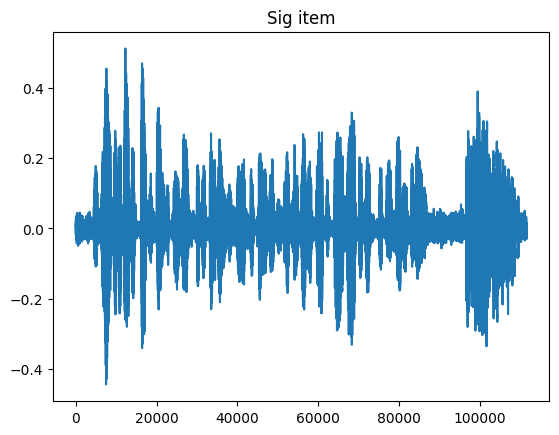

In [42]:
print(dataset[0])
import matplotlib.pyplot as plt
plt.figure(1)
plt.title("Sig item")
plt.plot(dataset[0]["signal"])
plt.show()

In [43]:
## applying our own functions

import soundfile as sf
@speechbrain.utils.data_pipeline.takes("file_path")
@speechbrain.utils.data_pipeline.provides("sig_numpy")
def audio_pipeline_numpy(file_path):
      sig, _ = sf.read(file_path, dtype="float32")
      return sig

In [44]:
speechbrain.dataio.dataset.add_dynamic_item([dataset], audio_pipeline_numpy) 
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["signal", "file_path", "sig_numpy"],
    )
dataset[0]

{'signal': tensor([ 0.0109, -0.0131, -0.0111,  ...,  0.0056,  0.0109,  0.0095]),
 'file_path': '/media/voxLingua/hi/pS2L7-_mxO4__U__S11---0316.180-0323.160.wav',
 'sig_numpy': array([ 0.01089478, -0.01306152, -0.01113892, ...,  0.00561523,
         0.01086426,  0.00952148], dtype=float32)}

{'sig': tensor([ 0.0109, -0.0131, -0.0111,  ...,  0.0056,  0.0109,  0.0095]), 'rand_gain_sig': tensor([ 0.0056, -0.0067, -0.0057,  ...,  0.0029,  0.0056,  0.0049]), 'offset_sig': tensor([1.0109, 0.9869, 0.9889,  ..., 1.0056, 1.0109, 1.0095])}


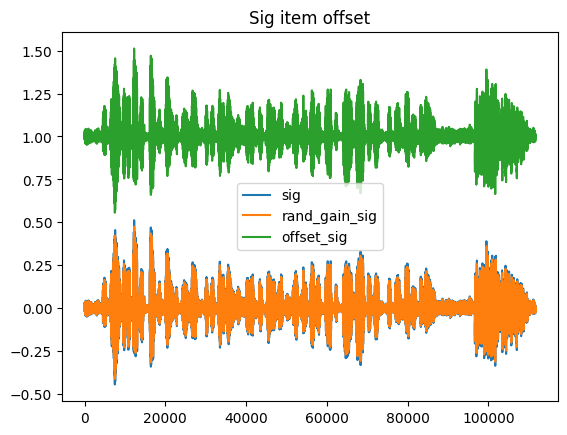

In [45]:
import random
@speechbrain.utils.data_pipeline.takes("file_path")
@speechbrain.utils.data_pipeline.provides("sig", "rand_gain_sig", "offset_sig")
def audio_pipeline(file_path):
      sig = speechbrain.dataio.dataio.read_audio(file_path)
      yield sig
      rand_gain_sig = random.random()*sig
      yield rand_gain_sig
      offset_sig = sig + 1
      yield offset_sig


speechbrain.dataio.dataset.add_dynamic_item([dataset], audio_pipeline) 
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["sig", "rand_gain_sig", "offset_sig"],
    )

print(dataset[0])
import matplotlib.pyplot as plt
plt.figure(1)
plt.title("Sig item")
plt.plot(dataset[0]["sig"])

plt.title("Sig item with random gain")
plt.plot(dataset[0]["rand_gain_sig"])

plt.title("Sig item offset")
plt.plot(dataset[0]["offset_sig"])
plt.legend(["sig", "rand_gain_sig", "offset_sig"])
plt.show()

In [46]:
@speechbrain.utils.data_pipeline.takes("sig")
@speechbrain.utils.data_pipeline.provides("sig_as_python_list")
def to_list_pipeline(sig):
      yield sig.numpy().tolist()


speechbrain.dataio.dataset.add_dynamic_item([dataset], to_list_pipeline) 
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["sig_as_python_list"],
    )
dataset[0]["sig_as_python_list"][:10]

[0.010894775390625,
 -0.0130615234375,
 -0.011138916015625,
 -0.011749267578125,
 -0.00372314453125,
 -0.012176513671875,
 -0.0177001953125,
 -0.004364013671875,
 0.00146484375,
 0.012939453125]

In [12]:
from speechbrain.dataio.encoder import CategoricalEncoder
lang_id_encoder = CategoricalEncoder()

In [13]:
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["language"],
    )
# sig is a torch.tensor with audio signal as specified before. 
# REMEMBER: no need to specify the pipeline for spkID as we can read directly the value from the JSON. 
dataset[0]

{'language': 'hi'}

In [14]:
lang_id_encoder.update_from_didataset(dataset, "language")

In [15]:
len(lang_id_encoder)

4

In [16]:
 lang_id_encoder.lab2ind

{'hi': 0, 'te': 1, 'en': 2, 'ta': 3}

In [17]:
lang_id_encoder.ind2lab

{0: 'hi', 1: 'te', 2: 'en', 3: 'ta'}

In [20]:
@speechbrain.utils.data_pipeline.takes("language")
@speechbrain.utils.data_pipeline.provides("lang_encoded")
def lang_id_encoding(langid):
      return torch.LongTensor([spk_id_encoder.encode_label(langid)]) 

speechbrain.dataio.dataset.add_dynamic_item([dataset], lang_id_encoding) 
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["lang_encoded"],
    )

dataset[100]

{'lang_encoded': tensor([0])}